# Data Access Tutorial

Let's get started setting up your environment. First let's clone this github directory somewhere on your perlmutter home directory so you can follow along, then if you haven't recently updated your desc kernels go ahead and do this. This will prevent old software issues during the week.


<div markdown="1" style="background-color:rgba(230, 230, 250, 0.8); text-align:left; vertical-align: middle; padding:10px; width:900px; border:solid;">
<p style='margin-left:1em;'>
    
* Log in to jupyter notebooks on NERSC 
     > https://jupyter.nersc.gov/
* Git clone this repo (You can select File&#8594;New&#8594;Terminal to open up a terminal window, and in your home directory type)
     > git clone https://github.com/LSSTDESC/SprintWeek2024.git
* Set up your kernels (in the same terminal window type the following)
    > source /global/common/software/lsst/common/miniconda/setup_current_python.sh
* Open tutorial in a notebook with the desc-python kernel
</p></span>
<div>

<div markdown="1" style="background-color:rgba(200, 230, 250, 0.4); text-align:left; vertical-align: middle; padding:10px; width:900px;">
<p>

### Background: GCR Catalogs/ The Data Registry /Parquet

[GCRCatalogs](https://github.com/LSSTDESC/gcr-catalogs) is a DESC project which aims at gathering in one convenient location various simulation/data catalogs made available to the collaboration. This was designed to make it easy to read in many types of data (simulations and precursor data from various groups) which all have different formats and units, and convert them to a unified interface. This has been very useful for simulated data validation when catalog formats are constantly evolving. 

For LSST data releases the formats and schema of the data are for the most part now set. This means that the GCR is simply using parquet to filter and return the data as a dictionary - I'm using it here as a shortcut at times, but will also show you how to do the parquet read. To do a direct read you need the file location and metadata, in future the data registry will provide this but as it's currently in a testing phase I'll show you how to access this through the GCR.  


</p></span>
<div>

As always we need to start with some basic preamble. The only new thing here should be to add the system path for the SRV version of the GCR catalogs (the DP0.2 reader will be merged in with the main one eventually but for now it's available here) before we read in the catalog reader.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/gcr-catalogs-test')
import GCRCatalogs

%matplotlib inline

A significant numbers of cosmology catalogs besides the DP0.2 object catalogs are also available through the GCR, use `sorted(GCRCatalogs.get_available_catalogs(False))` to see a full list and visit the [DC2 Data Product](https://confluence.slac.stanford.edu/display/LSSTDESC/DC2+Data+Product+Overview) page to see all the DC2-related catalogs. We're going to use the DP0.2 object catalogs, so let's look for those. I've called the catalog we're looking for lsst_object. Let's look for possible cadidates. 

In [27]:
for catalog in sorted(GCRCatalogs.get_available_catalogs(False)):
    if 'lsst' in catalog:
        print(catalog)

lsst_SSI
lsst_SSI_uninjected
lsst_object
lsst_object_full


You'll see some SSI catalogs here (synthetic source injection catalogs), as well as the full object catalog and a smaller version of the object catalog (only 1 tract of data). For now let's use lsst_object as the full dataset is a little large for everyone to read in at the same time! 

In [3]:
catalog = GCRCatalogs.load_catalog('lsst_object')

### DP0.2 object catalog Schema

The quantities available in the catalog can be found on the project website here: https://sdm-schemas.lsst.io/dp02.html, but we can also access these from the GCR in the following way. Note that these methods are equivalent, for this specific catalog named lsst_object we have done no quantity translation and so it's safe to assume that these follow the lsst conventions exactly. 

<div markdown="1" style="background-color:rgba(200, 230, 250, 0.4); text-align:middle; vertical-align: middle; padding:10px; width:900px;">
<p style='margin-left:100em;'>

### GCR Note

For those of you familiar with the GCR, you would normally look at list_all_quantities in a catalog with quantity modifiers. However the lsst reader used here is designed to exactly read in the Parquet data with no modifiers, so you instead look at list_all_native_quantities to get those directly. An example of non-native quantities is if we define modifiers to do useful things like convert fluxes to magnitudes, or define complex filter sets. 

Note that for comparisons between the DP0.2 and DC2 object catalogs you may prefer to use a translation layer to convert the DP0.2 catalog into DC2 conventions before read-in, this is possible by swapping to the dp02_object_single_tract catalog rather than lsst_object, and using the quantities list rather than the native_quantities list. Many validation tests are currently designed to work with this translation layer to enable such comparisons.

</p></span>
<div>

In [5]:
quantity_list = sorted(catalog.list_all_native_quantities())
for i in range(4):
    q = quantity_list[i]
    info = catalog.get_quantity_info(q)
    print(q)
    print('------------------')
    print(info['description'])
    print('Type: ' + info['type'] + ',', 'Units: ' + info['unit'])
    print(' ')

coord_dec
------------------
Fiducial ICRS Declination of centroid used for database indexing
Type: double, Units: deg
 
coord_ra
------------------
Fiducial ICRS Right Ascension of centroid used for database indexing
Type: double, Units: deg
 
deblend_nChild
------------------
Number of children this object has (defaults to 0)
Type: int32, Units: none
 
deblend_skipped
------------------
Deblender skipped this source
Type: boolean, Units: none
 


## Accessing the dataset through the GCR

Typically in the GCR we list the quantities we require, filters we want to cut these on, and any native filters we want to cut on. Native filters define the set of files to include within the group so tend to result in a more efficient filter.  

### Notation and format
- Filters are defined using strings (e.g. filters = ['r_ra > 0', 'r_decl < 0']) , these are converted to parquet formatting through the reader 
- specifying return_iterator=True will return the data iteratively, for this catalog we combine the files into a pyarrow dataset and iterative outputs are computed using the default to_batches method. 

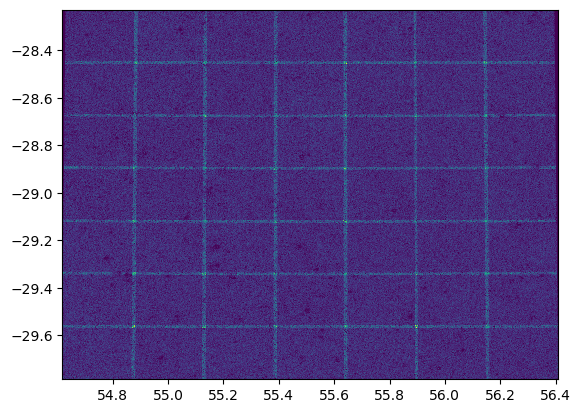

In [8]:
data = catalog.get_quantities(["r_ra","r_decl"])  
plt.figure()
plt.hist2d(data["r_ra"],data["r_decl"],bins=500)
plt.show()

### Hmm, that looks weird..

Luckily for us I've added a handy panic button to the notebook (sorry I couldn't justify the time to make it clickable!)

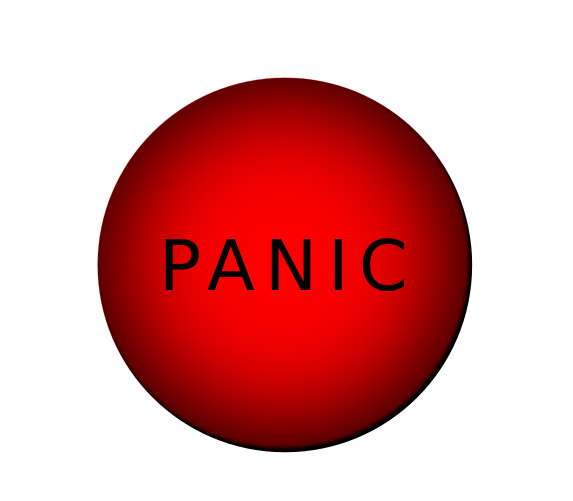

The lesson here is to be careful what you wish for! If you want to directly read the data we need to take the time to understand it a little better before jumping in. What happened here is that duplicate objects measured at the boundaries between tracts and patches haven't been removed from the catalog, resulting in a bright grid hiding all our stars and galaxies. 

If you want to inspect a normal looking galaxy catalog, you need to apply filters to remove duplicate objects, false sky objects and stars from the catalog. I've got a draft description of the base LSST flags and filters that we would recommend always applying here:
https://lsstdesc.org/srv-dp02/tutorials/Rubin/tutorial7_SRV_releases.html.




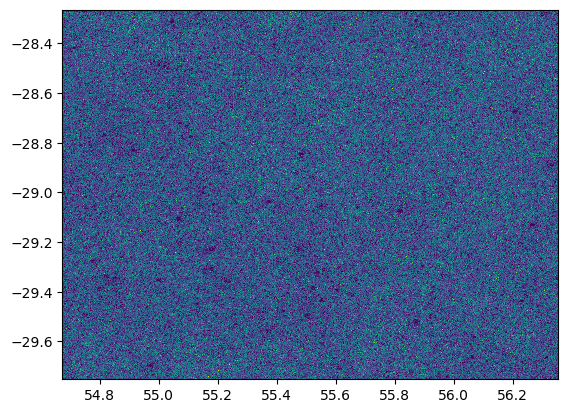

In [9]:
filters = ['detect_isPrimary','refExtendedness==1']
data = catalog.get_quantities(["r_ra","r_decl"], filters =filters)  

plt.figure()
plt.hist2d(data["r_ra"],data["r_decl"],bins=500)
plt.show()

### Time to update that button.. 

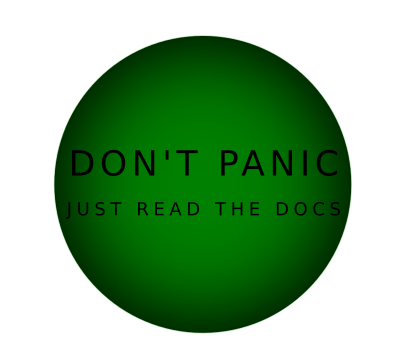


## Okay okay I get it, now what if I want to read the files directly?

Just remember a few things: 
* You'll need to know the locations (can do this either through the data registry - currently in beta phase, or through the GCR)
* There is no quantity translation so if two catalogs have different schema you'll have to resolve these
* Remember to take care of any necessary cuts, filters and catalog-level blinding

In [10]:
import pyarrow.compute as pc
import pyarrow.dataset as ds
from GCR.utils import concatenate_1d

In future we'd advise you to use the data registry, but for now you can access the datasets directly from the GCR catalog. Let's find the file corresponding to this (single-tract) catalog. 

In [12]:
for parquet_data in catalog._datasets:
    print('Dataset info: ', parquet_data.info)
    print('Dataset handle: ', parquet_data.handle)
    print('Dataset path: ', parquet_data.path)
    print(' ')

Dataset info:  {'tract': 4850}
Dataset handle:  <pyarrow.parquet.core.ParquetFile object at 0x7fa62969fc10>
Dataset path:  /global/cfs/cdirs/lsst/shared/rubin/DP0.2/objectTable/objectTable_tract_4850_DC2_2_2i_runs_DP0_2_v23_0_1_PREOPS-905_step3_27_20220316T171018Z.parq
 


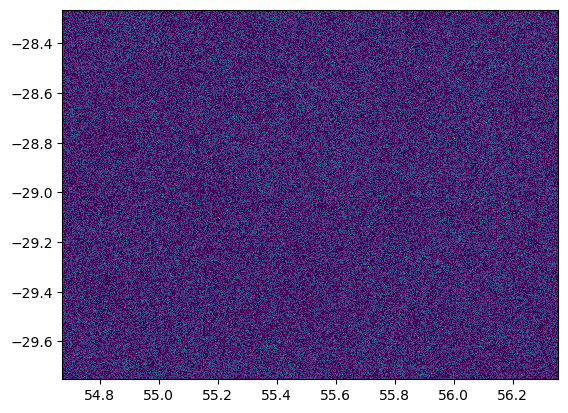

In [13]:
# take the file handles and combine them into a dataset (you can also provide the path if you want all files in the folder, 
# or in this case we can use a single file)
sources = [parquet_data.path for parquet_data in catalog._datasets]
dataset = ds.dataset(sources)

# the filter format is a little different, pc is pyarrow.compute
filter = pc.field('detect_isPrimary')& (pc.field("refExtendedness") == 1) 

# and let's try this with a batched read
ra_full = []
dec_full = []
for batch in dataset.to_batches(columns=["r_ra","r_decl"], filter=filter,):
    ra_full.append(batch["r_ra"])
    dec_full.append(batch["r_decl"])
time_end = time.time()

ra_full = concatenate_1d(ra_full)
dec_full = concatenate_1d(dec_full)

plt.hist2d(ra_full,dec_full,bins=1000)
plt.show()


<div markdown="1" style="background-color:rgba(200, 230, 250, 0.4); text-align:middle; vertical-align: middle; padding:10px; width:900px;">
<p style='margin-left:100em;'>

### I'm not familiar with parquet filters..  

Do I really need to convert all of these from the string format?

Lucky for you we convert these within the GCR already, so you can just import that function 
> from GCRCatalogs.parquet import convert_to_pyarrow_filter 

This can be useful if you're provided with a long list or are just unfamiliar with parquet filters. The full code is here:

```python
import re
import numexpr as ne

def convert_to_pyarrow_filter(filter_list):
    for i in range(len(filter_list)):
        for n in set(ne.necompiler.precompile(filter_list[i])[-1]):
            filter_list[i] = re.sub(rf"\b({n})\b", "pc.field(\"\\1\")", filter_list[i])
    total_query = eval(filter_list[0])
    
    if len(filter_list)>1:
        for i in range(1,len(filter_list)):
            total_query = total_query&eval(filter_list[i])
    return total_query
```

</p></span>
<div>

## Adding more filters

Let's try that again with the same functions as before, but this time let's refine the data a little better. As a shortcut I'm going to get a list of flags which I should require to be False from the GCR quantity modifiers: 

In [21]:
catalog.get_quantity_modifier('flags_bad')

(<function GCRCatalogs.lsst_object.create_false_flag_mask(*flags)>,
 'i_pixelFlags_bad',
 'i_pixelFlags_sensor_edgeCenter',
 'i_pixelFlags_offimage',
 'i_pixelFlags_clippedCenter',
 'i_pixelFlags_crCenter',
 'i_pixelFlags_interpolatedCenter',
 'i_pixelFlags_inexact_psfCenter',
 'i_pixelFlags_edge',
 'i_pixelFlags_suspectCenter',
 'i_pixelFlags_saturatedCenter',
 'i_pixelFlags_clipped',
 'i_pixelFlags_cr',
 'i_pixelFlags_interpolated',
 'i_pixelFlags_saturated',
 'i_pixelFlags_sensor_edge',
 'i_pixelFlags_suspect',
 'deblend_skipped',
 'i_centroid_flag',
 'i_cModel_flag',
 'i_gaapFlux_flag',
 'i_i_flag',
 'i_iPSF_flag',
 'i_hsmShapeRegauss_flag',
 'i_blendedness_flag')

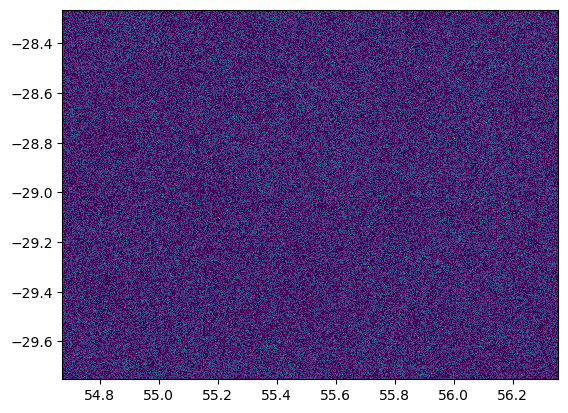

In [22]:

# take the file handles and combine them into a dataset
sources = [parquet_data.path for parquet_data in catalog._datasets]
dataset = ds.dataset(sources)

filter_list = [flag + '==False' for flag in catalog.get_quantity_modifier('flags_bad')[1:]]
filter_list += ['detect_isPrimary', 'refExtendedness == 1', "r_ra > 0", "r_decl < -40"]
filter_list_pyarrow = convert_to_pyarrow_filter(filter_list)

data = dataset.to_table(columns=["r_ra","r_decl"], filter=filter,)

plt.hist2d(data['r_ra'],data['r_decl'],bins=1000)
plt.show()


## Task! Get some data

Now we have some nice looking galaxy data!

In the next section we'll be creating a validation test on the PSF quantities. So let's started by reading in some data! With the filters detect_isPrimary, and refExtendedness ==1 (galaxies only), get the following quantities in the g band:

* From the DP0.2 schema look for the PSF shapes (use PSF rather than DebiasedPSF)
* Compute the trace of the PSF (ixx + iyy)
* Compute the complex ellipticity for the PSF moments (eq 7.5 of https://arxiv.org/pdf/2011.03409) 
* Look for cModel magnitudes, and read in the g band magnitudes (you'll need to convert from fluxes)
* Get RA/ DEC